In [1]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr, spearmanr, gmean
import statsmodels.formula.api as smf
%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data


# Read in expression and mutation

In [412]:
loader = read_data.DatasetLoader("CPTAC-3", load_methylation=False, load_expression=True)
cptac_expr, cptac_mut, _ = loader.load_dataset()
# pre-process
cptac_expr.scale_by_total_seq_depth()
cptac_expr.log_scale_expr()
# get dream gene expression
cptac_expr.get_dream_gene_expression(
    row_limiting_query = "harmine_dna_repair_up == 1 and indy_dna_repair_up == 1"
    )   
cptac_expr.dream_expression['mean_dream_reg_expr'] = cptac_expr.dream_expression[
    cptac_expr.dream_regulated_genes_w_expression
    ].mean(axis=1)
# select non metadata columns
cptac_expr.dream_expression['mean_overall_expr'] = cptac_expr.expression_df[
    [c for c in cptac_expr.expression_df.columns if c not in cptac_expr.meta_cols]
    ].mean(axis=1)
# get residual
ols = smf.ols(
    'mean_dream_reg_expr ~ total_seq_depth * n_genes_expressed',# * sample_type',
    data=cptac_expr.dream_expression
    ).fit()
cptac_expr.dream_expression['mean_dream_reg_expr_resid'] = ols.resid

Loading dataset: CPTAC-3
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_kidney_ccrcc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_headneck_hnscc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_headneck_hnscc_transpose.parquet
Unknown file type: /cellar/users/zkoc

# Read in phosphoproteomics

In [413]:
lin52_protein = 'NP_001019845.1'
rbl1_protein = 'NP_002886.2'

"""# kidney
kidney_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet",
    sep = "\t", index_col=0
    )
# keep only columns starting with lin52 or rbl1
kidney_phospho_df = kidney_phospho_df[
    [c for c in kidney_phospho_df.columns if c.startswith(lin52_protein) or c.startswith(rbl1_protein)]
    ]
# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(kidney_phospho_df.index)))
kidney_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr', 'sample_type', 'cancer_type']],
     kidney_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )"""

# uterus
uterus_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet",
    sep = "\t", index_col=0
    )
# keep only columns starting with lin52 or rbl1
uterus_phospho_df = uterus_phospho_df[
    [c for c in uterus_phospho_df.columns if c.startswith(lin52_protein) or c.startswith(rbl1_protein)]
    ]
# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(uterus_phospho_df.index)))
uterus_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr', 'sample_type', 'cancer_type']],
     uterus_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

# headneck
headneck_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_headneck_hnscc_transpose.parquet",
    sep = "\t", index_col=0
    )
# keep only columns starting with lin52 or rbl1
headneck_phospho_df = headneck_phospho_df[
    [c for c in headneck_phospho_df.columns if c.startswith(lin52_protein) or c.startswith(rbl1_protein)]
    ]
# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(headneck_phospho_df.index)))
headneck_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mean_overall_expr', 'sample_type', 'cancer_type']],
     headneck_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

phospho_dream_df = pd.concat([uterus_phospho_dream_df, headneck_phospho_dream_df])

# combine dream expression and mutation burden
dream_phospho_v_mut_burden = phospho_dream_df.merge(
     cptac_mut.mutation_burden['mutation_burden'], left_index=True, right_index=True, how='left'
    )

/tmp/ipykernel_1624367/1461820792.py:39: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,

# Read in proteomics and combine

In [414]:
# read in proto data 
headneck_proto_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_headneck_hnscc_transpose.parquet",
    sep = "\t", index_col=0
    )
headneck_protoPhospho_df = headneck_proto_df[['LIN52', 'RBL1']].merge(headneck_phospho_df, left_index=True, right_index=True, how = 'inner')
# drop rows where index is equal to nan
headneck_protoPhospho_df = headneck_protoPhospho_df[~headneck_protoPhospho_df.index.isna()]
# get rid of long sample lists
headneck_protoPhospho_df.reset_index(inplace = True)
headneck_protoPhospho_df['sample_id'] = headneck_protoPhospho_df['sample_id'].apply(lambda x: x.split(',')[0])
headneck_protoPhospho_df.set_index('sample_id', inplace = True)

# add mutations and dream
headneck_protoPhospho_df = headneck_protoPhospho_df.merge(cptac_expr.dream_expression , left_index=True, right_index=True, how = 'left')
headneck_protoPhospho_df = headneck_protoPhospho_df.merge(cptac_mut.mutation_burden['mutation_burden'], left_index=True, right_index=True, how='left')
headneck_protoPhospho_df = headneck_protoPhospho_df[~headneck_protoPhospho_df.index.isna()]
# remove QC sampes
# remove index starting with 'QC' or containing 'sample'
headneck_protoPhospho_df = headneck_protoPhospho_df[~headneck_protoPhospho_df.index.str.contains('QC')]
headneck_protoPhospho_df = headneck_protoPhospho_df[~headneck_protoPhospho_df.index.str.contains('sample')]
headneck_protoPhospho_df = headneck_protoPhospho_df[~headneck_protoPhospho_df.index.str.contains('Tumor')]

uterus_proto_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_uterus_UCEC_transpose.parquet",
    sep = "\t", index_col=0
    )
uterus_protoPhospho_df = uterus_proto_df[['LIN52', 'RBL1']].merge(uterus_phospho_df, left_index=True, right_index=True, how = 'inner')
# get rid of long sample lists
uterus_protoPhospho_df.reset_index(inplace = True)
uterus_protoPhospho_df['sample_id'] = uterus_protoPhospho_df['sample_id'].apply(lambda x: x.split(',')[0])
uterus_protoPhospho_df.set_index('sample_id', inplace = True)
# drop rows where index is equal to nan
uterus_protoPhospho_df = uterus_protoPhospho_df[~uterus_protoPhospho_df.index.isna()]
# add mutations and dream
uterus_protoPhospho_df = uterus_protoPhospho_df.merge(cptac_expr.dream_expression , left_index=True, right_index=True, how='left')
uterus_protoPhospho_df = uterus_protoPhospho_df.merge(cptac_mut.mutation_burden['mutation_burden'], left_index=True, right_index=True, how='left')
uterus_protoPhospho_df = uterus_protoPhospho_df[~uterus_protoPhospho_df.index.isna()]
# remove QC sampes
# remove index starting with 'QC' or containing 'sample'
uterus_protoPhospho_df = uterus_protoPhospho_df[~uterus_protoPhospho_df.index.str.contains('QC')]
uterus_protoPhospho_df = uterus_protoPhospho_df[~uterus_protoPhospho_df.index.str.contains('sample')]
uterus_protoPhospho_df = uterus_protoPhospho_df[~uterus_protoPhospho_df.index.str.contains('Tumor')]

# strangely kidney does not have lin52 or RBL1

protoPhospho_df = pd.concat([headneck_protoPhospho_df, uterus_protoPhospho_df])

protoPhospho_df.rename(columns = {'NP_001019845.1:s28': 'LIN52s28', 'NP_002886.2:s640': 'RBL1s640'}, inplace = True)
# convert all to float62
protoPhospho_df[['RBL1', 'LIN52s28','RBL1s640', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mutation_burden']] = protoPhospho_df[['RBL1', 'LIN52s28','RBL1s640', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid', 'mutation_burden']].astype('float64')

In [426]:
# just phospho
ols = smf.ols(
    'mean_dream_reg_expr ~ LIN52s28 * RBL1s640 * cancer_type', data=protoPhospho_df#.query("sample_type == 'Primary Tumor'"),
    # ignore nan
    #missing='drop'
    ).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_dream_reg_expr   R-squared:                       0.326
Model:                             OLS   Adj. R-squared:                  0.292
Method:                  Least Squares   F-statistic:                     9.680
Date:                 Thu, 01 Feb 2024   Prob (F-statistic):           8.57e-10
Time:                         12:33:03   Log-Likelihood:                -116.77
No. Observations:                  148   AIC:                             249.5
Df Residuals:                      140   BIC:                             273.5
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    1.5482      0.129     12.036      0.000       1.294       1.803
cancer_type[T.Squamous cell carcinoma]                      -0.2275      0.142     -1.607      0.110      -0.507       0.052
LIN52s28                                                     0.0802      0.129      0.622      0.535      -0.175       0.335
LIN52s28:cancer_type[T.Squamous cell carcinoma]             -0.1165      0.137     -0.848      0.398      -0.388       0.155
RBL1s640                                                     0.1526      0.128      1.190      0.236      -0.101       0.406
RBL1s640:cancer_type[T.Squamous cell carcinoma]              0.6005      0.168      3.573      0.000       0.268       0.933
LIN52s28:RBL1s640                                           -0.0024      0.102     -0.023      0.982      -0.204       0.199
LIN52s28:RBL1s640:cancer_type[T.Squamous cell carcinoma]     0.1949      0.143      1.364      0.175      -0.088       0.477
==============================================================================
Omnibus:                        9.941   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.175
Skew:                           0.634   Prob(JB):                      0.00617
Kurtosis:                       3.207   Cond. No.                         9.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [427]:
# just proto
ols = smf.ols(
    'mean_dream_reg_expr ~ LIN52 * RBL1 * cancer_type', data=protoPhospho_df#.query("sample_type == 'Primary Tumor'"),
    # ignore nan
    #missing='drop'
    ).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_dream_reg_expr   R-squared:                       0.255
Model:                             OLS   Adj. R-squared:                  0.226
Method:                  Least Squares   F-statistic:                     8.621
Date:                 Thu, 01 Feb 2024   Prob (F-statistic):           4.44e-09
Time:                         12:33:17   Log-Likelihood:                -166.17
No. Observations:                  184   AIC:                             348.3
Df Residuals:                      176   BIC:                             374.1
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             1.7900      0.062     28.821      0.000       1.667       1.913
cancer_type[T.Squamous cell carcinoma]               -0.3697      0.095     -3.893      0.000      -0.557      -0.182
LIN52                                                 0.2503      0.095      2.643      0.009       0.063       0.437
LIN52:cancer_type[T.Squamous cell carcinoma]          0.2554      0.245      1.041      0.299      -0.229       0.740
RBL1                                                  0.3667      0.098      3.750      0.000       0.174       0.560
RBL1:cancer_type[T.Squamous cell carcinoma]           0.3224      0.175      1.843      0.067      -0.023       0.668
LIN52:RBL1                                           -0.2327      0.174     -1.334      0.184      -0.577       0.112
LIN52:RBL1:cancer_type[T.Squamous cell carcinoma]     0.6570      0.530      1.240      0.216      -0.388       1.702
==============================================================================
Omnibus:                        6.876   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.130
Skew:                           0.476   Prob(JB):                       0.0283
Kurtosis:                       2.843   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [432]:
# both
ols = smf.ols(
    'mean_dream_reg_expr ~ LIN52 * LIN52s28  + RBL1 * RBL1s640 ', data=protoPhospho_df.query("sample_type == 'Primary Tumor' and cancer_type == 'Squamous cell carcinoma'"),
    ).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mutation_burden   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.159
Method:                 Least Squares   F-statistic:                    0.3155
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.923
Time:                        12:34:41   Log-Likelihood:                -233.86
No. Observations:                  31   AIC:                             481.7
Df Residuals:                      24   BIC:                             491.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        409.7856    126.974      3.227      0.004     147.724     671.848
LIN52            134.6329    322.711      0.417      0.680    -531.410     800.676
LIN52s28          28.0163     67.992      0.412      0.684    -112.312     168.345
LIN52:LIN52s28  -138.8732    257.096     -0.540      0.594    -669.493     391.747
RBL1            -227.1443    396.576     -0.573      0.572   -1045.637     591.349
RBL1s640        -169.2821    189.276     -0.894      0.380    -559.928     221.364
RBL1:RBL1s640    180.1846    395.136      0.456      0.652    -635.335     995.705
==============================================================================
Omnibus:                       29.439   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.443
Skew:                           2.351   Prob(JB):                     4.09e-12
Kurtosis:                       7.300   Cond. No.                         9.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [433]:
# both
ols = smf.ols(
    'mean_dream_reg_expr ~ (LIN52 + RBL1) * (RBL1s640 + LIN52s28) * cancer_type', data=protoPhospho_df#.query("sample_type == 'Primary Tumor'"),
    ).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_dream_reg_expr   R-squared:                       0.604
Model:                             OLS   Adj. R-squared:                  0.523
Method:                  Least Squares   F-statistic:                     7.522
Date:                 Thu, 01 Feb 2024   Prob (F-statistic):           7.40e-11
Time:                         12:34:55   Log-Likelihood:                -57.506
No. Observations:                  102   AIC:                             151.0
Df Residuals:                       84   BIC:                             198.3
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 1.1857      0.226      5.241      0.000       0.736       1.636
cancer_type[T.Squamous cell carcinoma]                    0.1540      0.237      0.651      0.517      -0.317       0.625
LIN52                                                     1.1901      0.538      2.212      0.030       0.120       2.260
LIN52:cancer_type[T.Squamous cell carcinoma]             -1.0045      0.582     -1.726      0.088      -2.162       0.153
RBL1                                                     -0.2330      0.207     -1.125      0.264      -0.645       0.179
RBL1:cancer_type[T.Squamous cell carcinoma]               0.7353      0.264      2.786      0.007       0.210       1.260
RBL1s640                                                  0.1569      0.195      0.803      0.424      -0.232       0.545
RBL1s640:cancer_type[T.Squamous cell carcinoma]           0.3624      0.239      1.519      0.133      -0.112       0.837
LIN52s28                                                  0.4937      0.380      1.300      0.197      -0.262       1.249
LIN52s28:cancer_type[T.Squamous cell carcinoma]          -0.4967      0.383     -1.298      0.198      -1.258       0.264
LIN52:RBL1s640                                           -0.3416      0.495     -0.690      0.492      -1.327       0.643
LIN52:RBL1s640:cancer_type[T.Squamous cell carcinoma]     0.8014      0.609      1.316      0.192      -0.410       2.012
LIN52:LIN52s28                                           -0.1279      0.756     -0.169      0.866      -1.631       1.375
LIN52:LIN52s28:cancer_type[T.Squamous cell carcinoma]    -0.1476      0.769     -0.192      0.848      -1.677       1.382
RBL1:RBL1s640                                             0.1446      0.186      0.778      0.439      -0.225       0.514
RBL1:RBL1s640:cancer_type[T.Squamous cell carcinoma]     -0.0561      0.259     -0.217      0.829      -0.571       0.459
RBL1:LIN52s28                                             0.3769      0.279      1.352      0.180      -0.178       0.931
RBL1:LIN52s28:cancer_type[T.Squamous cell carcinoma]     -0.1170      0.304     -0.385      0.701      -0.721       0.487
==============================================================================
Omnibus:                        3.513   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                3.287
Skew:                           0.439   Prob(JB):                        0.193
Kurtosis:                       2.968   Cond. No.                         49.3
==============================================================================

Notes:
[1] Standard Errors assume t

In [448]:
# both
ols = smf.ols(
    'LIN52s28 ~ LIN52 * cancer_type * sample_type', data=protoPhospho_df#.query("sample_type == 'Primary Tumor'"),
    ).fit()
ols.summary()
protoPhospho_df['LIN52s28_resid'] = ols.resid

# Phosphorylation vs. DREAM vs. mutations

In [440]:
# min max scale LIN52s28 within cancer type
protoPhospho_df['LIN52s28_scaled'] = protoPhospho_df.groupby('cancer_type')['LIN52s28'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
protoPhospho_df['LIN52_scaled'] = protoPhospho_df.groupby('cancer_type')['LIN52'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
protoPhospho_df['LIN52_scaled:LIN52s28_scaled']= protoPhospho_df['LIN52_scaled'] * protoPhospho_df['LIN52s28_scaled']

In [453]:
# both
ols = smf.ols(
    'mutation_burden ~ LIN52s28 *  LIN52 * cancer_type', data=protoPhospho_df#.query("sample_type == 'Primary Tumor'"),
    ).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mutation_burden   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.021
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.422
Time:                        12:55:24   Log-Likelihood:                -829.96
No. Observations:                 101   AIC:                             1676.
Df Residuals:                      93   BIC:                             1697.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                               816.8583    177.843      4.593      0.000     463.697    1170.019
cancer_type[T.Squamous cell carcinoma]                 -538.2703    231.296     -2.327      0.022    -997.579     -78.961
LIN52s28                                               -103.7019    200.230     -0.518      0.606    -501.320     293.916
LIN52s28:cancer_type[T.Squamous cell carcinoma]          99.6485    223.725      0.445      0.657    -344.625     543.923
LIN52                                                   -50.4448    221.389     -0.228      0.820    -490.080     389.190
LIN52:cancer_type[T.Squamous cell carcinoma]            133.9637    537.860      0.249      0.804    -934.120    1202.047
LIN52s28:LIN52                                           82.8905    217.565      0.381      0.704    -349.151     514.932
LIN52s28:LIN52:cancer_type[T.Squamous cell carcinoma]  -128.3011    445.349     -0.288      0.774   -1012.675     756.073
==============================================================================
Omnibus:                      102.378   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1166.920
Skew:                           3.404   Prob(JB):                    4.04e-254
Kurtosis:                      18.196   Cond. No.                         8.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [456]:
protoPhospho_df.index.value_counts().drop_duplicates()

sample_id
C3N-03710-03    3
C3L-04186-01    2
C3L-00977-02    1
C3L-02412-01    1
C3L-02744-01    1
               ..
C3N-03008-03    1
C3N-03008-01    1
C3N-02925-01    1
C3N-02730-01    1
C3N-06305-01    1
Name: count, Length: 337, dtype: int64

(0.0, 400.0)

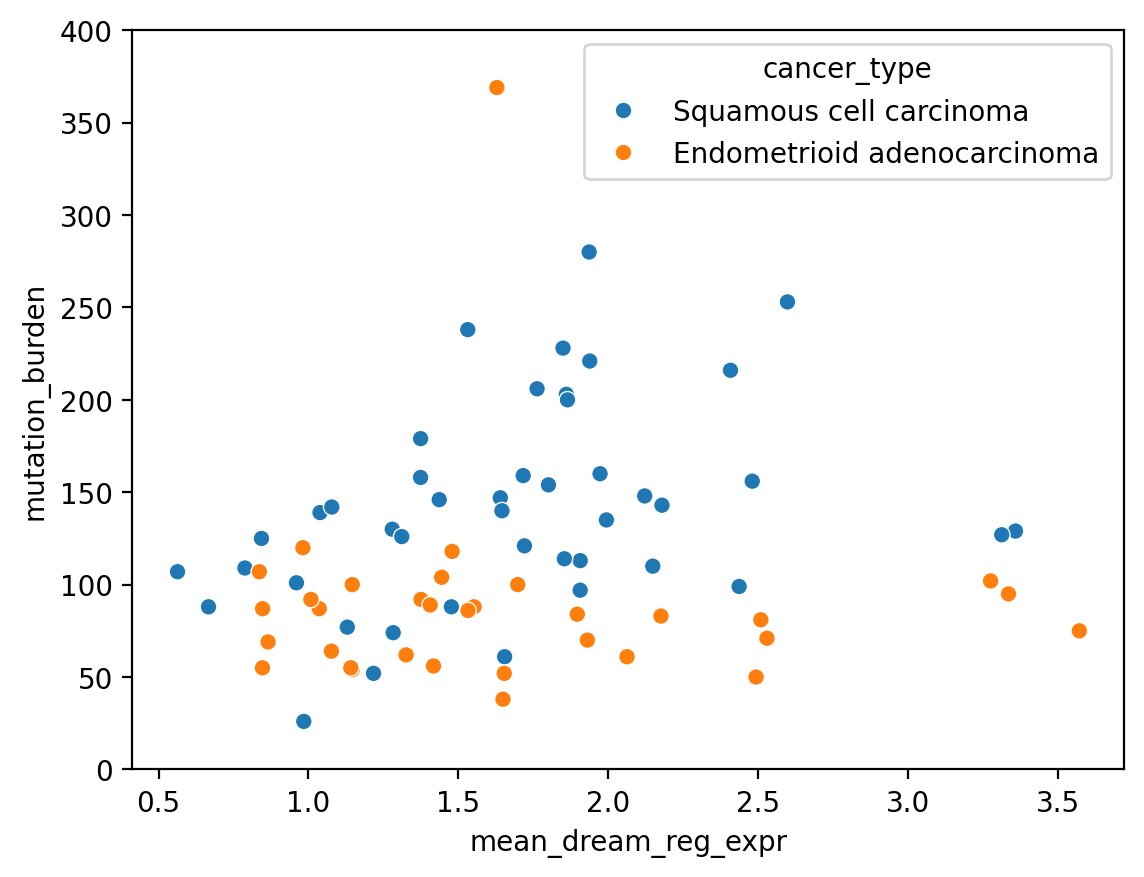

In [466]:
sns.scatterplot(
    data = protoPhospho_df.query("sample_type == 'Primary Tumor'"),
    x = 'mean_dream_reg_expr', y = 'mutation_burden', hue = 'cancer_type'
    )
#plt.yscale('log')
plt.ylim(0, 400)
